In [297]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

X_train=pd.read_csv('X_train.csv')
X_test=pd.read_csv('X_test.csv')
y_train=pd.read_csv('y_train.csv')
y_test=pd.read_csv('y_test.csv')

In [298]:
#Ici nous normalisons les données

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

cols=['Log GDP per capita','Social support','Healthy life expectancy at birth','Freedom to make life choices','Generosity',
      'Perceptions of corruption','Positive affect','Negative affect']

X_train[cols]=scaler.fit_transform(X_train[cols])
X_test[cols]=scaler.transform(X_test[cols])

In [207]:
#Une fois les données normalisés on peut lancer les modélisations classification
#Les données de Life Ladder que nous avons actuellement est un score sur 10, il s'agit de variables continues.
#A premier abord il s'agit d'un probleme de regression. Cependant si nous transformons ces notes en catégories comme score :
#Très Bas, Bas, Moyen, Haut, Très Haut.

In [299]:
#Pour cela, analysons la distibution des scores de life ladder

df_global2=pd.read_csv('df_global2.csv')

df_global2['Life Ladder'].describe()

count    2098.000000
mean        5.471402
std         1.112676
min         2.375000
25%         4.652250
50%         5.392000
75%         6.282500
max         8.019000
Name: Life Ladder, dtype: float64

In [300]:
#Comme nous pouvons nous en apercevoir avec la description du Life Ladder, le score min est 2.37, le score max est 8.01
#La médiane et la moyenne sont quasiment égales vers 5.40
#Nous repartissons alors le LIFE LADDER en 5 catégorie : 

#-Très bas : LL < 3,5
#-Bas : LL >=3,5 et <4,63
#-Moyen: LL >=4,63 et <5,76
#-Haut: LL >=5,76 et <6,89
#-Très Haut >=6,89

In [301]:
# On créer une fonction pour déterminer la categorie

def categorie(valeur):
    if valeur < 3.5:
        return 'Très bas'
    elif valeur >= 3.5 and valeur <= 4.63:
        return 'Bas'
    elif valeur >= 4.63 and valeur <= 5.76:
        return 'Moyen'
    elif valeur >= 5.76 and valeur <= 6.89:
        return 'Haut'
    else:
        return 'Très Haute'

y_train['Categorie Life Ladder'] = y_train['Life Ladder'].apply(categorie)
y_train=y_train.drop('Life Ladder',axis=1)
y_train.head(3)

,Categorie Life Ladder
0,Moyen
1,Haut
2,Haut


In [302]:
#On applique la meme chose a y_test

y_test['Categorie Life Ladder'] = y_test['Life Ladder'].apply(categorie)
y_test=y_test.drop('Life Ladder',axis=1)


y_test.head(3)

,Categorie Life Ladder
0,Haut
1,Bas
2,Haut


In [303]:
y_train=y_train['Categorie Life Ladder'].values
y_test=y_test['Categorie Life Ladder'].values

In [304]:
#Nous avons maintenant X_train, X_test, y_train, y_test dans un format adéquat aux modèles de classification

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dtc = tree.DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

print('Score sur ensemble train', dtc.score(X_train, y_train))
print('Score sur ensemble test', dtc.score(X_test, y_test))

#Il y a ici un suraprentissage évident car le score sur le jeu d'entrainement est à 1 et le score sur le jeu de test à 0.65


Score sur ensemble train 1.0
Score sur ensemble test 0.6571428571428571


In [305]:
#On réduit le nombre minimal d'individus requis pour une séparation de noeud avec les parametres max_depth et min_sample_leaf

dtc2 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 25, random_state=42)

dtc2.fit(X_train, y_train)

print('Score sur ensemble train', dtc2.score(X_train, y_train))

print('Score sur ensemble test', dtc2.score(X_test, y_test))

#En jouant sur les deux parametres max_depth et min_sample_leaf on arrive a avoir des score legerement meilleurs.
#Bien que le score sur le jeu d'entraînement ait légèrement baissé, on constate que l'écart entre le score sur le
#jeu d'entraînement et le score sur le jeu de test est réduit. On décide donc de poursuivre 
#avec ce modèle qui généralise mieux sur les données qu'il ne connaît pas.

#0.68 n'étant toujours pas exceptionelle on va essayer de voir les variables les plus importantes dans le mode de calcul de 
#L'algoritme

Score sur ensemble train 0.7067938021454112
Score sur ensemble test 0.680952380952381


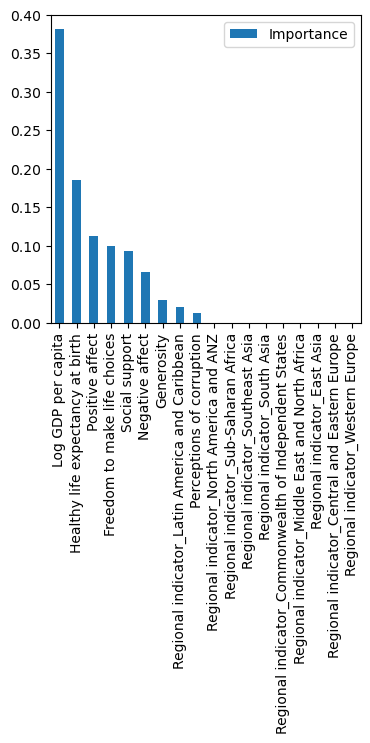

In [306]:
import matplotlib.pyplot as plt
%matplotlib inline
feat_importances = pd.DataFrame(dtc2.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(4,4));

In [307]:
X_train_new = X_train[['Log GDP per capita','Healthy life expectancy at birth','Positive affect',"Social support"]]
X_test_new = X_test[['Log GDP per capita','Healthy life expectancy at birth','Positive affect',"Social support"]]

dtc2 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 25, random_state=42)

dtc2.fit(X_train_new, y_train)

print('Score sur ensemble train', dtc2.score(X_train_new, y_train))

print('Score sur ensemble test', dtc2.score(X_test_new, y_test))

#Ce n'est pas forcement necessaire, au contraire sur ce coup ci car cela réduit la performance du modèle. On ne peut donc pas
#mieux faire que 0.68 sur le modele d'arbre de classification. Passons à un autre modèle

Score sur ensemble train 0.6912991656734208
Score sur ensemble test 0.6452380952380953


In [308]:
#LA REGRESSION LOGISTIQUE
from sklearn.linear_model import LogisticRegression

#Pour supprimer le message d'erreur suivant : "TOTAL NO. of ITERATIONS REACHED LIMIT"
#j'ajoute un nombre d'iteration a 1000 ce qui améliore legerement le modele.

LR = LogisticRegression(max_iter=1000,random_state=42)

LR.fit(X_train,y_train)

print("Score sur jeu d'entrainement :",LR.score(X_train,y_train))
print("Score sur jeu de test :",LR.score(X_test,y_test))

#Score legerement supérieur à la méthode d'arbre de classification mais un score bas sur le jeu d'entrainement. Voyons une
#autre méthode d'algorithme.

Score sur jeu d'entrainement : 0.6591179976162098
Score sur jeu de test : 0.6952380952380952


In [309]:
#LE RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print('Score sur ensemble train', rf.score(X_train, y_train))
print('Score sur ensemble test', rf.score(X_test, y_test))

#Il s'agit pour le moment du modèle de classification le plus performant.
#Voyons comment nous pourrions l'améliorer.

Score sur ensemble train 1.0
Score sur ensemble test 0.7619047619047619


In [310]:
#Ce modele random forest étant interessant on peut se demander comment l'optimiser. Il est possible de travailler sur les 
#hyperparametres comme nous avons fait pour le modele d'arbre de classification.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300,max_depth=20)
rf.fit(X_train, y_train)

print('Score sur ensemble train', rf.score(X_train, y_train))
print('Score sur ensemble test', rf.score(X_test, y_test))

#On voit que nous pouvons améliorer les scores gràce aux hyperparametres. Mais je le fais à la mains. 
#Cela pourrait être interessant d'utiliser un outil permetant de comprendres quels combinaisons sont les meilleures.
#Pour cela nous allons utiliser GridSearchCV.


Score sur ensemble train 1.0
Score sur ensemble test 0.7619047619047619


In [1]:
from sklearn.model_selection import GridSearchCV
grille_hyperp={
    'n_estimators':[None,50,100,200,300,500],
    'max_depth':[None,5,10,20,30,50],
    'min_samples_split':[None,2,5,6]}

grid_search = GridSearchCV(RandomForestClassifier(),grille_hyperp , cv=5)

grid_search.fit(X_train, y_train)

#Ce que je comprend ici quand il a fini de tourner la premiere fois 
#c'est qu'au mieux on peut monter jusqu'a 0,77 donc on était pas mal 

NameError: name 'RandomForestClassifier' is not defined

In [312]:
from sklearn.metrics import accuracy_score, classification_report
#Random Forsest = rf
#Regression Logistique = LR
#l'arbre de classification = dtc2

rf_predictions = rf.predict(X_test)
dtc2_predictions = dtc2.predict(X_test_new)
LR_predictions = LR.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
dtc2_accuracy = accuracy_score(y_test, dtc2_predictions)
LR_accuracy = accuracy_score(y_test, LR_predictions)

rf_report = classification_report(y_test, rf_predictions)
dtc2_report = classification_report(y_test, dtc2_predictions)
LR_report = classification_report(y_test, LR_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Decision Tree Accuracy:", dtc2_accuracy)
print("Logistic Regression Accuracy:", LR_accuracy)

print("\nRandom Forest Classification Report:")
print(rf_report)
print("\nDecision Tree Classification Report:")
print(dtc2_report)
print("\nLogistic Regression Classification Report:")
print(LR_report)

#Pour comparer les modèles de classifications on utilise en premier l'accuracy car c'est la méthode la plus connue pour evaluer
#un modele de classification. Elle correspond au taux de prédictions correctes effectuées par le modèle 

#On édite quand meme un rapport de classification afin de se rendre compte des predictions sur chaque classe et pour voir si il
#y a des désequilibres entre les classes.

#Après avoir fais un bref rappel de chaque metrique on peut dire que le random forest est la plus précise et donc celle a choisir
#comme modèle de classification bien qu'elle mériterait encore quelques ajustement pour la rendre plus précise.

Random Forest Accuracy: 0.7619047619047619
Decision Tree Accuracy: 0.6452380952380953
Logistic Regression Accuracy: 0.6952380952380952

Random Forest Classification Report:
              precision    recall  f1-score   support

         Bas       0.73      0.81      0.77       100
        Haut       0.78      0.78      0.78       112
       Moyen       0.74      0.76      0.75       142
  Très Haute       0.87      0.79      0.83        52
    Très bas       0.75      0.21      0.33        14

    accuracy                           0.76       420
   macro avg       0.77      0.67      0.69       420
weighted avg       0.76      0.76      0.76       420


Decision Tree Classification Report:
              precision    recall  f1-score   support

         Bas       0.72      0.63      0.67       100
        Haut       0.59      0.70      0.64       112
       Moyen       0.62      0.65      0.63       142
  Très Haute       0.72      0.73      0.72        52
    Très bas       0.00      

C:\Users\user\anaconda4\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda4\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda4\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda4\Lib\site-packages\sklearn\metrics\